In [14]:
import torch
import torchvision
import time
import random
import math
import json

from operator import add
from PIL import Image, ImageFont, ImageDraw

In [15]:
targets_test = [
    {'boxes':torch.FloatTensor([[0,0],[0,0]]), 'labels':torch.LongTensor([1,0,0,0])}
]

In [89]:
loadingStrings = [' ','▏','▎','▍','▌','▋','▊','▉','█']
def printLoadingBar(percentage:float, length:int, startTime:float):
    if percentage==0.0:
        print(" " + "_"*length)
    
    nbFilled = max(0, min(length, int(length*percentage)))
    remainder = length*percentage - int(length*percentage)
    strRemainder = loadingStrings[int(remainder*len(loadingStrings))]
    strPercentage = "{0:.2f}%".format(100*percentage) 
    isBarFull = int(nbFilled!=length)
    bar = "▕" + "█"*(nbFilled) + isBarFull*strRemainder + " "*(length-nbFilled-1) + "▏" + strPercentage
    
    ellapsedTime = time.time() - startTime
    eta = 0.0 if percentage==0.0 else ellapsedTime*((1-percentage)/percentage)
    isMinute = int(int(eta)>=60)
    isZero = int(percentage<0.99999)
    strEta = isMinute*"{0}m".format(int(eta)//60) + isZero*"{0}s".format(int(eta)%60)
    
    buffer = " "*(length+20)
    
    print(buffer,end="\r")
    print(bar + " " + strEta,end="\r")

In [16]:
texturesList = [Image.open('./Textures/parchment-bg-filter.png')]
fontsList = ['./Fonts/SoulGlyph.ttf','./Fonts/SoulVector.ttf']

In [17]:
alphabet = ['*','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
random.seed(100)
alphabetColors = [(random.randrange(256),random.randrange(256),random.randrange(256)) for i in alphabet]
def displayCoords(image, coords, labels):
    font = ImageFont.truetype("meiryo.ttc", 20)
    imageCopy = image.copy()
    draw = ImageDraw.Draw(imageCopy)
    for i in range(len(coords)):
        coord = coords[i]
        label = labels[i]
        x1 = coord[0]
        y1 = coord[1]
        x2 = coord[2]
        y2 = coord[3]
        color = alphabetColors[label]
        
        draw.rectangle([x1,y1,x2,y2], outline=color, width=2)
        draw.text((x1+2,y1), alphabet[label], color, font=font)
        
    display(imageCopy)

In [18]:
def rotateBox(box:list, angle:float, center:tuple) -> list:
    angleRad = math.pi*angle/180
    
    x1,y1,x2,y2 = box
    x1=x1-center[0]
    x2=x2-center[0]
    y1=-(y1-center[1])
    y2=-(y2-center[1])
    
    
    cos=math.cos(angleRad)
    sin=math.sin(angleRad)
    newXs = [
        x1*cos-y1*sin,
        x2*cos-y1*sin,
        x1*cos-y2*sin,
        x2*cos-y2*sin
    ]
    
    newYs = [
        -(x1*sin+y1*cos),
        -(x2*sin+y1*cos),
        -(x1*sin+y2*cos),
        -(x2*sin+y2*cos)
    ]
    """
    tl = (x1*cos-y1*sin, x1*sin+y1*cos)
    tr = (x2*cos-y1*sin, x2*sin+y1*cos)
    bl = (x1*cos-y2*sin, x1*sin+y2*cos)
    br = (x2*cos-y2*sin, x2*sin+y2*cos)
    """
    return [min(newXs)+center[0], min(newYs)+center[1], max(newXs)+center[0], max(newYs)+center[1]]
    
    

In [19]:
def createImage(pixelSize=(600,600), resizeDim=(800,800), labels=[], nPerturbs=5, font=None, yBaseOffset=0,angle=0,seed=0) -> Image:
    random.seed(seed)
    
    info = {'boxes' : [], 'labels' : []}
    padding = 0
    
    foreground=(random.randrange(256),random.randrange(256),random.randrange(256), 255)
    background=(random.randrange(256),random.randrange(256),random.randrange(256))
    """
    distance = abs(foreground[0]+foreground[1]+foreground[2]-background[0]-background[1]-background[2])
    modif = 255//(distance+1)
    background=(background[0]*modif,background[1]*modif,background[2]*modif)
    """
    distance = (foreground[0]+foreground[1]+foreground[2]-background[0]-background[1]-background[2])
    signDist = int(math.copysign(1,distance))
    modif = 10*255//(distance+signDist)
    background=(background[0]-modif,background[1]-modif,background[2]-modif)
    foreground=(foreground[0]+modif,foreground[1]+modif,foreground[2]+modif, 255)
    
    baseFontSize = font.size
    
    image1 = Image.new(mode='RGBA', size=pixelSize, color=(255,255,255,0))
    draw1 = ImageDraw.Draw(image1)
    
    perturb_font = ImageFont.truetype("yumin.ttf", baseFontSize)
    perturb_foreground=(random.randrange(256),random.randrange(256),random.randrange(256), 255)
    perturbs = [alphabet[random.randrange(len(alphabet)+1)-1] for i in range(nPerturbs)]
    
    #Draw perturbations
    for perturb in perturbs:
        x0,y0,width,height = perturb_font.getbbox(perturb)
        
        randXOffset = random.randrange(pixelSize[0] - baseFontSize)
        randYOffset = random.randrange(pixelSize[1] - baseFontSize)
        fontOffsetX = randXOffset
        fontOffsetY = yBaseOffset*baseFontSize + randYOffset
        draw1.text((fontOffsetX,fontOffsetY), perturb, perturb_foreground, font=perturb_font)
        info['boxes'].append([
            randXOffset-padding, 
            fontOffsetY-padding, 
            randXOffset+width+padding, 
            fontOffsetY+height+padding
        ])
        info['labels'].append(0) #0 is for background
    
    #Draw Glyphs
    for label in labels:
        symbol = alphabet[label+1]
        x0,y0,width,height = font.getbbox(symbol)
        
        randXOffset = random.randrange(pixelSize[0] - baseFontSize)
        randYOffset = random.randrange(pixelSize[1] - baseFontSize)
        fontOffsetX = randXOffset
        fontOffsetY = yBaseOffset*baseFontSize + randYOffset
        draw1.text((fontOffsetX,fontOffsetY), symbol, foreground, font=font)
        info['boxes'].append([
            randXOffset-padding, 
            fontOffsetY-padding, 
            randXOffset+width+padding, 
            fontOffsetY+height+padding
        ])
        info['labels'].append(label+1) #0 is for background
    
    #letters rotation
    sampling = Image.Resampling.BICUBIC
    text_rot = image1.copy().rotate(angle,sampling,expand=True)
    
    
    backgroundPic = Image.new(mode='RGB', size=text_rot.size, color=background)
    
    #prepare texture for use in background
    texture = texturesList[random.randrange(len(texturesList))]
    pos_texture = (random.randrange(-texture.size[0],pixelSize[0]) , random.randrange(-texture.size[1],pixelSize[1]))
    backgroundPic.paste(texture,pos_texture,texture.split()[-1])
    
    image_rot = backgroundPic.copy()
    image_rot.paste(text_rot, (0, 0), text_rot.split()[-1])
    
    #update coords after rotation
    newPixelSize = (text_rot.size[0],text_rot.size[1])
    dx = (newPixelSize[0]-pixelSize[0])/2
    dy = (newPixelSize[1]-pixelSize[1])/2
    dV = [dx,dy,dx,dy]
    info['boxes'] = [list(map(add, boxes, dV)) for boxes in info['boxes']] # add the differences of size due to the rotation
    info['boxes'] = [rotateBox(box,angle,(newPixelSize[0]/2,newPixelSize[1]/2)) for box in info['boxes']]
    
    #Resizing (compress/dilate)   data=(a,b,c,d,e,f) -> point(x',y') = (x*a + y*b + c, x*d + y*e + f)
    ratioX = resizeDim[0]/newPixelSize[0]
    ratioY = resizeDim[1]/newPixelSize[1]
    affineData = (1/ratioX,0,0, 0,1/ratioY,0)
    image_rot = image_rot.copy().transform(resizeDim, Image.Transform.AFFINE, data=affineData, resample=Image.Resampling.NEAREST)
    info['boxes'] = [[box[0]*ratioX,box[1]*ratioY,box[2]*ratioX,box[3]*ratioY,] for box in info['boxes']]
    
    return image_rot, info

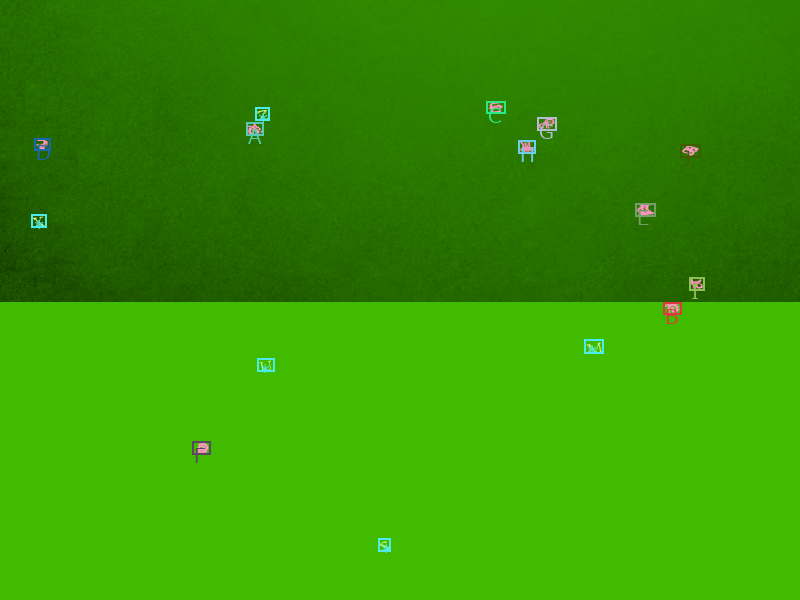

In [20]:
img_test,info_test = createImage(
    pixelSize=(600,600),
    resizeDim=(800,600),
    labels=[0,1,2,3,4,5,6,7,8,9],
    nPerturbs=5,
    font=ImageFont.truetype("./Fonts/SoulGlyph.ttf", 15),
    yBaseOffset=0.0,
    angle=10.0,
    seed=12
)

displayCoords(img_test, info_test['boxes'], info_test['labels'])

In [73]:
alphaSpace = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',' ',' ',' ',' ',' ']
def createWordImage(pixelSize=(600,600),resizeDim=(800,800), nPerturbs=5, font=None, yBaseOffset=0,angle=0,seed=0) -> Image:
    random.seed(seed)
    
    info = {'boxes' : [], 'labels' : []}
    padding = 0
    
    foreground=(random.randrange(256),random.randrange(256),random.randrange(256), 255)
    background=(random.randrange(256),random.randrange(256),random.randrange(256))
    
    """
    distance = abs(foreground[0]+foreground[1]+foreground[2]-background[0]-background[1]-background[2])
    modif = 255//(distance+1)
    background=(background[0]*modif,background[1]*modif,background[2]*modif)
    """
    distance = (foreground[0]+foreground[1]+foreground[2]-background[0]-background[1]-background[2])
    signDist = int(math.copysign(1,distance))
    modif = 10*255//(distance+signDist)
    background=(background[0]-modif,background[1]-modif,background[2]-modif)
    foreground=(foreground[0]+modif,foreground[1]+modif,foreground[2]+modif, 255)
    
    baseFontSize = font.size
    
    image1 = Image.new(mode='RGBA', size=pixelSize, color=(255,255,255,0))
    
    draw1 = ImageDraw.Draw(image1)
    
    
    perturb_font = ImageFont.truetype("yumin.ttf", baseFontSize)
    perturb_foreground=(random.randrange(256),random.randrange(256),random.randrange(256), 255)
    
    #Draw Glyphs
    nx = (pixelSize[0]-2*padding)//baseFontSize
    ny = (pixelSize[1]-2*padding)//baseFontSize
    
    y=padding
    maxLabel=26 #Make sure that the first symbol is not a space
    for j in range(ny):
        x=padding
        for i in range(nx):
            isPerturb = random.randrange(6) == 0
            label = random.randrange(maxLabel)
            symbol = alphaSpace[label] if (random.randrange(2) == 0) else alphaSpace[label].upper()
            usedFont = perturb_font if isPerturb else font
            
            x0,y0,width,height = usedFont.getbbox(symbol)
            
            maxOffsetX = baseFontSize//8
            fontOffsetX = random.randrange(-maxOffsetX,max(1,maxOffsetX))
            fontOffsetY = yBaseOffset*baseFontSize
            draw1.text((x+fontOffsetX,y+fontOffsetY), symbol, foreground, font=usedFont)
            
            
            if label+1 < len(alphabet):
                recordedLabel = int(not isPerturb)*(label+1)  #0 is for background
                info['boxes'].append([
                    x+fontOffsetX-padding, 
                    y-padding, 
                    x+width+fontOffsetX+padding, 
                    y+height+padding
                ])
                info['labels'].append(recordedLabel) 
            
            maxLabel = len(alphaSpace)
            x+=width
        y+=baseFontSize
    
    #Letters rotation
    sampling = Image.Resampling.BICUBIC
    text_rot = image1.rotate(angle,sampling,expand=True)
    
    backgroundPic = Image.new(mode='RGB', size=text_rot.size, color=background)
    
    #prepare texture for use in background
    texture = texturesList[random.randrange(len(texturesList))]
    pos_texture = (random.randrange(-texture.size[0],pixelSize[0]) , random.randrange(-texture.size[1],pixelSize[1]))
    backgroundPic.paste(texture,pos_texture,texture.split()[-1])
    
    #update coords after rotation
    newPixelSize = (text_rot.size[0],text_rot.size[1])
    dx = (newPixelSize[0]-pixelSize[0])/2
    dy = (newPixelSize[1]-pixelSize[1])/2
    dV = [dx,dy,dx,dy]
    info['boxes'] = [list(map(add, box, dV)) for box in info['boxes']] # add the differences of size due to the rotation
    info['boxes'] = [rotateBox(box,angle,(newPixelSize[0]/2,newPixelSize[1]/2)) for box in info['boxes']]
    
    image_rot = backgroundPic.copy()
    image_rot.paste(text_rot, (0, 0), text_rot.split()[-1])
    
    #Resizing (compress/dilate)   data=(a,b,c,d,e,f) -> point(x',y') = (x*a + y*b + c, x*d + y*e + f)
    ratioX = resizeDim[0]/newPixelSize[0]
    ratioY = resizeDim[1]/newPixelSize[1]
    affineData = (1/ratioX,0,0, 0,1/ratioY,0)
    image_rot = image_rot.copy().transform(resizeDim, Image.Transform.AFFINE, data=affineData, resample=Image.Resampling.NEAREST)
    info['boxes'] = [[box[0]*ratioX,box[1]*ratioY,box[2]*ratioX,box[3]*ratioY,] for box in info['boxes']]
    
    #image_rot.show()
    return image_rot, info

(589, 683)


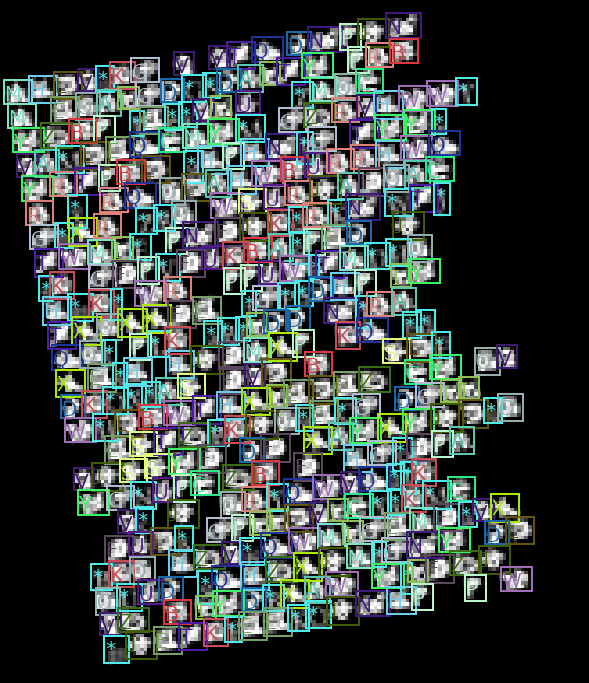

In [74]:
img_test2,info_test2 = createWordImage(
    pixelSize=(134, 173),
    resizeDim=(589, 683),
    nPerturbs=5,
    font=ImageFont.truetype("./Fonts/SoulGlyph.ttf", 7),
    yBaseOffset=0.0,
    angle=10.0,
    seed=14
)
print(img_test2.size)
displayCoords(img_test2, info_test2['boxes'], info_test2['labels'])

In [93]:
def createTrainingSet():
    
    start = time.time()
    nb_images = 20000
    list_info = []
    
    printLoadingBar(0.0,20,start)
    for i in range(nb_images):
        random.seed(420+i)
        
        
        nbSelected = random.randrange(4,13)
        nPerturbs = random.randrange(4,13)
        labels = [random.randrange(0,26) for i in range(nbSelected)]
        angle = random.uniform(-10,10)
        
        
        truefontSize = random.randrange(100,240)
        maxDims = 800
        minDims = int(truefontSize*1.3)
        resizeDim = (random.randrange(minDims,maxDims),random.randrange(minDims,maxDims))
        resizeDim = (maxDims , int(maxDims*resizeDim[1]/resizeDim[0])) if resizeDim[0]>resizeDim[1] else (int(maxDims*resizeDim[0]/resizeDim[1]) , maxDims)
        pixelWidth = random.randrange(200,maxDims)
        
        #ratioDim = resizeDim[1]/resizeDim[0]
        scaleRatio = pixelWidth/resizeDim[0]
        
        maxHeight = 1.2*scaleRatio*resizeDim[1]
        minHeight = 0.8*scaleRatio*resizeDim[1]
        pixelSize = (pixelWidth , int(random.uniform(minHeight,maxHeight)))
        usedFontSize = int(scaleRatio*truefontSize)
        
        fontName = fontsList[random.randrange(len(fontsList))]
        """
        if(i==14):
            print(resizeDim)
            print(pixelSize)
            print(truefontSize)
            print(usedFontSize)
        """
        """
        #maxObj = 8
        maxObj = min()
        nbObjectPerSide = random.randrange(1, maxObj)
        maxFontSize = max(pixelSize[0],pixelSize[1])
        maxFontResize = max(resizeDim[0],resizeDim[1])
        fontResize = random.randrange(int(0.9*maxFontResize/nbObjectPerSide), int(1.1*maxFontResize/nbObjectPerSide))
        fontSize = fontResize*maxFontSize//maxFontResize
        pixelSize = (max(fontSize+1,pixelSize[0]), max(fontSize+1,pixelSize[1]))
        """
        #letters = [alphabet[i] for i in labels]
        
        if False: #random.randrange(2)==0: #impossible mode
            nPerturbs = random.randrange(0, max(1,nbObjectPerSide//2))+1
            nbSelected = random.randrange(0, max(1,nbObjectPerSide))+1
            labels = [random.randrange(0,26) for i in range(nbSelected)]
            #print(str(maxFontSize)+" "+str(fontSize)+" "+str(maxFontSize//fontSize))
            img, info = createImage(
                pixelSize=pixelSize,
                resizeDim=resizeDim,
                labels=labels,
                nPerturbs=nPerturbs,
                font=ImageFont.truetype(fontName, usedFontSize),
                yBaseOffset=0,
                angle=angle,
                seed=i
            )
        else:
            #fontSize = random.randrange(maxFontSize//7,maxFontSize)
            img, info = createWordImage(
                pixelSize=pixelSize,
                resizeDim=resizeDim,
                nPerturbs=nPerturbs,
                font=ImageFont.truetype(fontName, usedFontSize),
                yBaseOffset=0,
                angle=angle,
                seed=i
            )
        #info['labels'].extend(labels)
        
        
        info['image']="./Test_Pictures/Image_" + str(i) + ".jpeg"
        img.save(info['image'])
        list_info.append(info)
        
        separator = nb_images//5000
        if i%separator==separator-1:
            printLoadingBar(i/nb_images,20,start)
            
            
    with open('targets.json', 'w', encoding="utf-8") as outfile:
        json.dump(list_info, outfile, indent=4)
            

In [94]:
createTrainingSet()

 ____________________


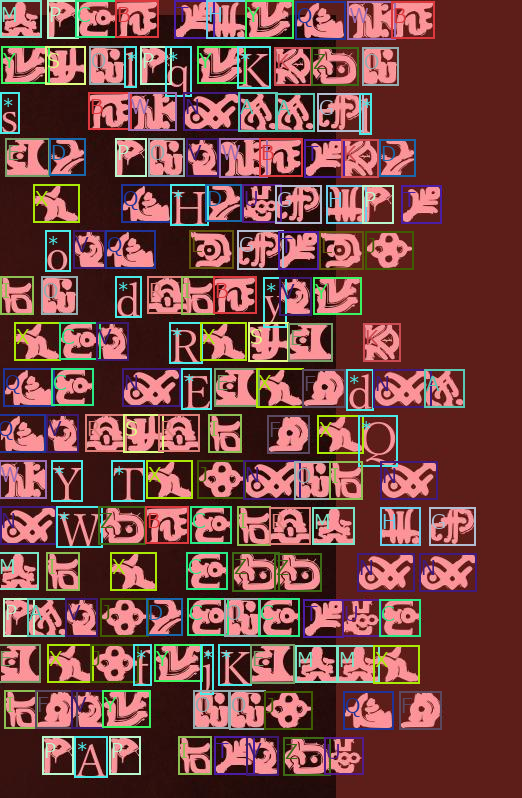

[13, 16, 3, 2, 20, 8, 25, 17, 23, 2, 25, 19, 15, 0, 16, 0, 25, 0, 11, 26, 15, 0, 2, 23, 14, 1, 1, 7, 0, 5, 4, 16, 15, 22, 23, 2, 20, 11, 4, 24, 17, 0, 4, 21, 7, 8, 16, 20, 0, 22, 17, 12, 7, 20, 12, 10, 9, 15, 0, 18, 9, 2, 0, 22, 25, 24, 3, 22, 0, 24, 19, 5, 11, 17, 3, 14, 0, 5, 24, 6, 0, 14, 1, 17, 22, 18, 19, 18, 9, 6, 24, 0, 23, 0, 0, 24, 10, 14, 15, 9, 14, 14, 0, 26, 2, 3, 9, 18, 13, 8, 7, 13, 9, 24, 3, 26, 26, 14, 14, 16, 1, 22, 10, 4, 3, 15, 3, 20, 21, 3, 5, 24, 10, 0, 25, 0, 0, 5, 13, 13, 24, 9, 6, 22, 25, 15, 15, 10, 17, 6, 16, 0, 16, 9, 20, 22, 26, 21]
[[-0.9037599309840516, 0.93017353328014, 41.10610156332021, 37.941368041246335], [47.09597179641881, 0.9429687590408093, 78.10610024874583, 38.95123099224111], [75.09623736880908, 0.9504326407345047, 116.10609889864239, 37.96136058149733], [115.09623594764759, 0.9610953288683959, 158.1060974064228, 37.9725564040379], [174.09596728423105, 0.9768227938658356, 214.1060954167967, 38.987484131896224], [206.09596614730185, 0.9853529443

In [46]:
with open('targets.json', 'r', encoding="utf-8") as f:
    image_nb = 27 #7 #23
    infos = json.load(f)
    test_img = Image.open(infos[image_nb]['image'])
    displayCoords(test_img, infos[image_nb]['boxes'], infos[image_nb]['labels'])
    print(infos[image_nb]['labels'])
    print(infos[image_nb]['boxes'])
    